In [1]:
#importing all the libraries needed for this implementation. The warnings module was introduced as a way to warn 
#programmers about changes in language or library features in anticipation of backwards incompatible changes coming 
#with Python 3.0. Since warnings are not fatal, a program may encounter the same warn-able situation many times in 
#the course of running a program
#The filter is set to ignore so that the warnings are not displayed
import warnings
warnings.filterwarnings('ignore')
#The main purpose of the OS module is to interact with the operating system
import os
#The main purpose of the OS module is to interact with the operating system
import os
#Boto3 is the name of the Python SDK for AWS. The module makes it easy to integrate the Python application, library, or script with AWS services including Amazon S3 and more
#It allows for direct creation, updating and deletion of AWS resources from your Python scripts
import boto3
#Python io module allows us to manage the file-related input and output operations
import io
#SageMaker Python SDK is an open-source library for training and deploying machine learning models on Amazon SageMaker
import sagemaker
#For matrix operations and numerical processing
import numpy as np
#for munging tabular data
import pandas as pd
#For charts and visualizations 
from matplotlib import pyplot as plt
%matplotlib inline
#Scikit-learn is a machine learning library for Python. It features several regression, classification and clustering 
#algorithms including SVMs, gradient boosting, k-means, random forests and DBSCAN. . Using train_test_split() from the
#data science library scikit-learn, you can split your dataset into subsets that minimize the potential for bias in 
#your evaluation and validation process.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#With Scikit-Learn it is extremely straight forward to implement linear regression models, as all you really need to 
#do is import the LinearRegression class, instantiate it, and call the fit() method along with our training data.
from sklearn.linear_model import LinearRegression
#Import seaborn, a library for making statistical graphics in Python
import seaborn
#importing other modules that makr it easier to work with the data
import pickle,gzip,urllib,json,csv
#The preprocessing module provides the StandardScaler utility class, which is a quick and easy way to perform the 
#many operations on an array-like dataset
from sklearn import preprocessing

In [2]:
#Get the execution role for the notebook instance. This is the IAM role that you created for your notebook instance.
#You pass the role to the tuning job.
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
#Resources represent an object-oriented interface to Amazon Web Services (AWS). They provide a higher-level 
#abstraction than the raw, low-level calls made by service clients. Defining the S3 resource, bucket name and csv
#file object
s3 = boto3.resource('s3')
bucket_name = 'aws-machinelearning-chez'
object_key = 'weatherhistory2.csv'

In [4]:
#Use the boto3 client to retrieve the file from bucket aws-machinelearning-chez named weatherhistory.csv. 
#Define Weather dataset as the csv file read in the response from the get_object operation
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
response_body = response["Body"].read()
weather_df = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [5]:
#Look at the data
weather_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


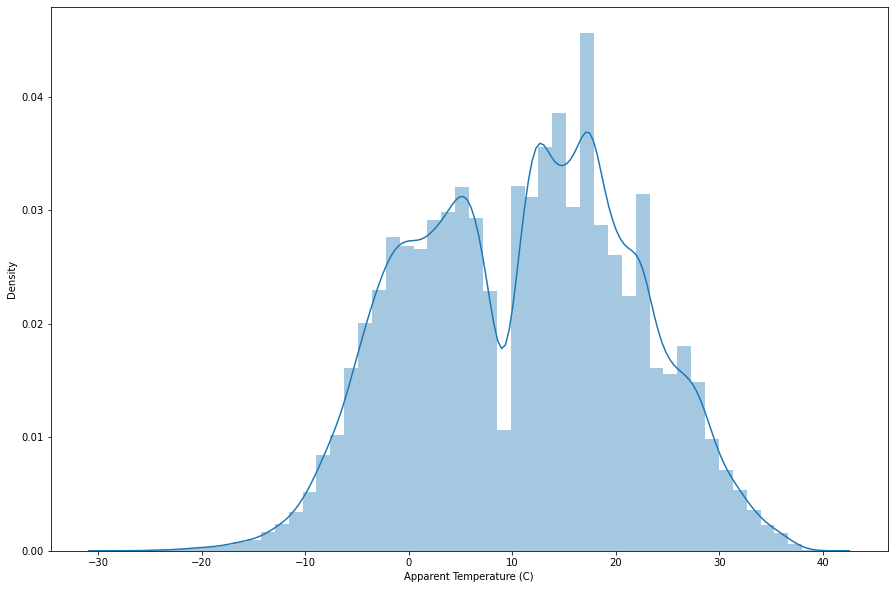

In [7]:
#A seaborn plot enables us to visualize a statistical plot of the raw data
plt.figure(figsize=(15,10))
plt.tight_layout()
seaborn.distplot(weather_df['Apparent Temperature (C)'])
plt.show()

In [8]:
#Gives an array of colums names 
weather_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

In [9]:
#Prints the shape of the dataframe
weather_df.shape

(96453, 12)

In [10]:
#Generate descriptive statistics that summarize the central tendency, dispersion and shape of the dataset’s 
#distribution excluding NaN values
weather_df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [11]:
weather_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [12]:
#Prints a concise summary of the dataframe
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  int64  
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  int64  
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 8.8+ MB


In [13]:
#check if there is any null value in a particular column
weather_df.isnull().any()

Formatted Date              False
Summary                     False
Precip Type                  True
Temperature (C)             False
Apparent Temperature (C)    False
Humidity                    False
Wind Speed (km/h)           False
Wind Bearing (degrees)      False
Visibility (km)             False
Loud Cover                  False
Pressure (millibars)        False
Daily Summary               False
dtype: bool

In [14]:
#check if there are all null values in a particular column
weather_df.isnull().all()

Formatted Date              False
Summary                     False
Precip Type                 False
Temperature (C)             False
Apparent Temperature (C)    False
Humidity                    False
Wind Speed (km/h)           False
Wind Bearing (degrees)      False
Visibility (km)             False
Loud Cover                  False
Pressure (millibars)        False
Daily Summary               False
dtype: bool

In [15]:
#calculate the percentage of null values in each column
round(100*(weather_df.isnull().sum()/len(weather_df.index)),2)

Formatted Date              0.00
Summary                     0.00
Precip Type                 0.54
Temperature (C)             0.00
Apparent Temperature (C)    0.00
Humidity                    0.00
Wind Speed (km/h)           0.00
Wind Bearing (degrees)      0.00
Visibility (km)             0.00
Loud Cover                  0.00
Pressure (millibars)        0.00
Daily Summary               0.00
dtype: float64

In [16]:
#determine what values are in this column and what the count is of each value
weather_df['Precip Type'].value_counts()

rain    85224
snow    10712
Name: Precip Type, dtype: int64

In [17]:
#Handling missing values by imputation of the mode i.e. rain
weather_df.loc[weather_df['Precip Type'].isnull(),'Precip Type']='rain'

In [18]:
#calculate the percentage of null values in each column for the second time
round(100*(weather_df.isnull().sum()/len(weather_df.index)),2)

Formatted Date              0.0
Summary                     0.0
Precip Type                 0.0
Temperature (C)             0.0
Apparent Temperature (C)    0.0
Humidity                    0.0
Wind Speed (km/h)           0.0
Wind Bearing (degrees)      0.0
Visibility (km)             0.0
Loud Cover                  0.0
Pressure (millibars)        0.0
Daily Summary               0.0
dtype: float64

In [19]:
#Input binary values in Precip type column for rain and snow
weather_df.loc[weather_df['Precip Type']=='rain','Precip Type']=1
weather_df.loc[weather_df['Precip Type']=='snow','Precip Type']=0

In [20]:
weather_df_num=weather_df[list(weather_df.dtypes[weather_df.dtypes!='odject'].index)]

In [21]:
#Drop columns that are irrelevant to the model training
to_drop = ['Formatted Date','Summary','Daily Summary']
weather_df.drop(to_drop, inplace=True, axis=1)

In [22]:
#Separating the training and the test datasets. The feature that we are predicting is temperature, so we separate 
#it out into a column on its own (weather_y) leaving the rest of the data in weather_x
weather_df_y = weather_df_num.pop('Temperature (C)')
weather_df_x = weather_df_num

In [34]:
#In supervised machine learning, we add data to the model and tell it what the output will be based on the various 
#conditions of that data. The model then learns from these features and is then able to make a prediction for new 
#values 
#So we now split the data into train and test

train_x,test_x,train_y,test_y = train_test_split(weather_df_x,weather_df_y,test_size = 0.2,random_state=4)

In [35]:
#Look at the training dataset. It has all columns except the temperature column
train_x.head()

,Formatted Date,Summary,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
70626,2014-04-27 18:00:00.000 +0200,Partly Cloudy,1,21.061111,0.31,12.5580,110,16.1000,0,1005.87,Partly cloudy throughout the day.
52457,2011-09-30 17:00:00.000 +0200,Partly Cloudy,1,25.016667,0.36,18.4989,352,10.3523,0,1025.36,Partly cloudy starting in the morning continui...
90690,2016-01-13 21:00:00.000 +0100,Overcast,1,0.738889,0.89,17.1304,270,15.8263,0,1014.75,Partly cloudy overnight.
69528,2013-09-13 00:00:00.000 +0200,Overcast,1,13.772222,0.78,14.4900,300,15.8263,0,1014.56,Mostly cloudy throughout the day.
92419,2016-06-22 22:00:00.000 +0200,Partly Cloudy,1,23.288889,0.82,6.3917,357,16.1000,0,1022.05,Partly cloudy throughout the day.


In [38]:
weather_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,1,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13
1,1,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63
2,1,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94
3,1,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41
4,1,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51


In [39]:
train_x,test_x,train_y,test_y = train_test_split(weather_df_x,weather_df_y,test_size = 0.2,random_state=4)

In [40]:

#Look at the training dataset. It has all columns except the temperature column
train_x.head()

,Formatted Date,Summary,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
70626,2014-04-27 18:00:00.000 +0200,Partly Cloudy,1,21.061111,0.31,12.5580,110,16.1000,0,1005.87,Partly cloudy throughout the day.
52457,2011-09-30 17:00:00.000 +0200,Partly Cloudy,1,25.016667,0.36,18.4989,352,10.3523,0,1025.36,Partly cloudy starting in the morning continui...
90690,2016-01-13 21:00:00.000 +0100,Overcast,1,0.738889,0.89,17.1304,270,15.8263,0,1014.75,Partly cloudy overnight.
69528,2013-09-13 00:00:00.000 +0200,Overcast,1,13.772222,0.78,14.4900,300,15.8263,0,1014.56,Mostly cloudy throughout the day.
92419,2016-06-22 22:00:00.000 +0200,Partly Cloudy,1,23.288889,0.82,6.3917,357,16.1000,0,1022.05,Partly cloudy throughout the day.


In [42]:
#Look at the training dataset. It has all columns except the temperature column
train_x.head()

,Formatted Date,Summary,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
70626,2014-04-27 18:00:00.000 +0200,Partly Cloudy,1,21.061111,0.31,12.5580,110,16.1000,0,1005.87,Partly cloudy throughout the day.
52457,2011-09-30 17:00:00.000 +0200,Partly Cloudy,1,25.016667,0.36,18.4989,352,10.3523,0,1025.36,Partly cloudy starting in the morning continui...
90690,2016-01-13 21:00:00.000 +0100,Overcast,1,0.738889,0.89,17.1304,270,15.8263,0,1014.75,Partly cloudy overnight.
69528,2013-09-13 00:00:00.000 +0200,Overcast,1,13.772222,0.78,14.4900,300,15.8263,0,1014.56,Mostly cloudy throughout the day.
92419,2016-06-22 22:00:00.000 +0200,Partly Cloudy,1,23.288889,0.82,6.3917,357,16.1000,0,1022.05,Partly cloudy throughout the day.


In [43]:
#Drop columns that are irrelevant to the model training
to_drop = ['Formatted Date','Summary','Daily Summary']
train_x.drop(to_drop, inplace=True, axis=1)

In [44]:

#Look at the training dataset. It has all columns except the temperature column

train_x.head()

,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
70626,1,21.061111,0.31,12.5580,110,16.1000,0,1005.87
52457,1,25.016667,0.36,18.4989,352,10.3523,0,1025.36
90690,1,0.738889,0.89,17.1304,270,15.8263,0,1014.75
69528,1,13.772222,0.78,14.4900,300,15.8263,0,1014.56
92419,1,23.288889,0.82,6.3917,357,16.1000,0,1022.05


In [45]:

train_y.head()

70626    21.061111
52457    25.016667
90690     4.422222
69528    13.772222
92419    23.288889
Name: Temperature (C), dtype: float64

In [46]:
test_y.head()

37443    -2.288889
86534     8.861111
2082      9.805556
53130    27.222222
45196    17.705556
Name: Temperature (C), dtype: float64

In [47]:
test_x.shape

(19291, 11)

In [48]:
test_x.head()

,Formatted Date,Summary,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
37443,2010-02-15 03:00:00.000 +0100,Overcast,0,-6.255556,0.92,10.8192,341,6.0697,0,1008.36,Foggy starting in the evening.
86534,2015-10-21 18:00:00.000 +0200,Mostly Cloudy,1,8.861111,0.89,4.2987,262,9.9820,0,1017.62,Mostly cloudy starting in the morning continui...
2082,2006-12-04 18:00:00.000 +0100,Overcast,1,8.766667,0.83,8.1305,284,7.8729,0,1014.15,Overcast throughout the day.
53130,2012-04-29 18:00:00.000 +0200,Partly Cloudy,1,26.344444,0.24,22.5400,160,9.9820,0,1016.70,Partly cloudy starting in the morning continui...
45196,2011-08-05 04:00:00.000 +0200,Mostly Cloudy,1,17.705556,0.82,3.3166,17,15.8263,0,1014.93,Partly cloudy throughout the day.


In [49]:
#Drop columns that are irrelevant to the model training
to_drop = ['Formatted Date','Summary','Daily Summary']
test_x.drop(to_drop, inplace=True, axis=1)

In [50]:
test_x.head()

,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
37443,0,-6.255556,0.92,10.8192,341,6.0697,0,1008.36
86534,1,8.861111,0.89,4.2987,262,9.9820,0,1017.62
2082,1,8.766667,0.83,8.1305,284,7.8729,0,1014.15
53130,1,26.344444,0.24,22.5400,160,9.9820,0,1016.70
45196,1,17.705556,0.82,3.3166,17,15.8263,0,1014.93


In [51]:
test_x.shape

(19291, 8)

In [52]:
train_x.shape

(77162, 8)

In [53]:
#Now we train the model with the train_x values as well as the train_y values
model = LinearRegression()
model.fit(train_x,train_y)

LinearRegression()

In [54]:
#Once the model is trained, we then us the test data to make a prediction
prediction = model.predict(test_x)

In [57]:
df=pd.DataFrame({'actual':test_y,
             'prediction':prediction,
             'diff':(test_y-prediction)})

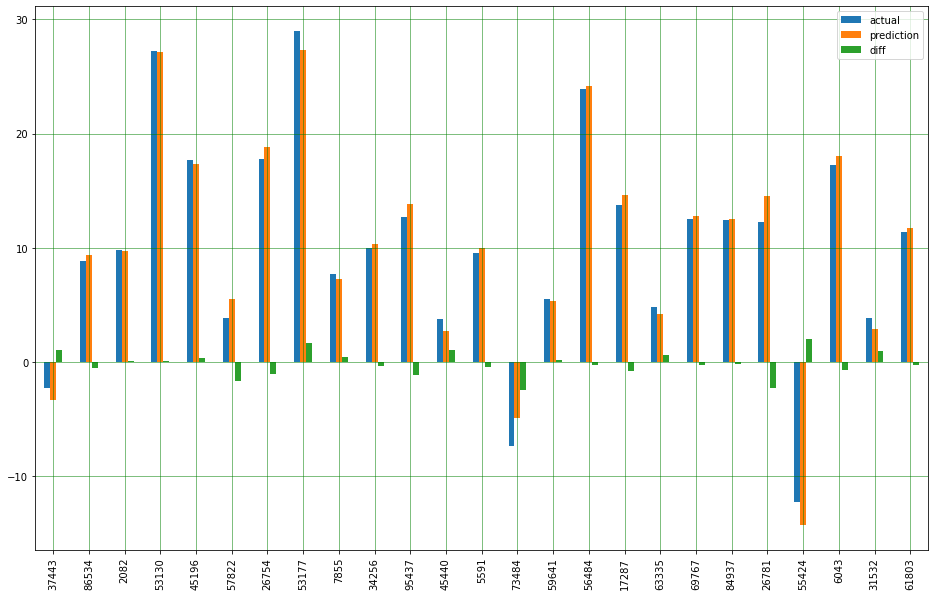

In [58]:

df1= df.head(25)
df1.plot(kind='bar', figsize=(16,10))
plt.grid(which='major', linestyle='-',linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':',linewidth='0.5', color='black')
plt.show()

In [60]:
#We then compare this prediction (output) to the test_y values and Calculate the error difference 
#between predicted value and actual value
np.mean((prediction-test_y)**2)

0.901887690903043

In [61]:
#Import metrics library
from sklearn import metrics

In [62]:
#Print results of MAE
print(metrics.mean_absolute_error(test_y, prediction))

0.7415821805238502


In [63]:
#Print results of MSE
print(metrics.mean_squared_error(test_y, prediction))

0.9018876909030483


In [64]:
#Print results of RMSE
print(np.sqrt(metrics.mean_squared_error(test_y, prediction)))

0.9496776773743018
